In [1]:
import numpy as np
import matplotlib.pyplot as plt


class Tube: 
    
    def __init__(self, tag, sframe, eframe):
        self.tag = tag
        self.sframe = sframe 
        self.eframe = eframe 
        self.posX = []
        self.posY = []

    def __len__(self):
        return len(self.posX)
        
    def add_position(self, x, y):
        self.posX.append(x)
        self.posY.append(y)

    def __iter__(self):
        self.currframe = 0
        return self

    def __next__(self):
        if self.currframe < len(self.posX):
            frame = self.sframe + self.currframe
            x = self.posX[self.currframe]
            y = self.posY[self.currframe]
            self.currframe += 1
            return x, y, frame
        else:
            raise StopIteration
    
    def __str__(self):
        return self.tag
    
    def plot(self):
        plt.scatter(self.posX, self.posY, s=100, label=self.tag)
        

In [71]:
from itertools import permutations

class Overlapping:
    def __init__(self, start, end):
        self.sframe = start
        self.eframe = end
    def __str__(self):
        return 'OVL'

class Intersection:
    def __init__(self, frame):
        self.frame = frame
    def __str__(self):
        return 'INT'
        
class RelationsMap:
    def __init__(self, tubes):
        self.tubes = tubes
        self.relations = {}
        for Ta in tubes:
            self.relations[Ta.tag] = {}
            for Tb in tubes:
                self.relations[Ta.tag][Tb.tag] = None

    def compute(self):        
        for Ta, Tb in permutations(self.tubes, 2):
            if Ta == Tb: continue
            # we focus on tube A and check the
            # intersections with Tube B. 
            f_inter = None
            l_inter  = None
            for xa, ya, frame in Ta:
                for xb, yb, _ in Tb:
                    d = np.linalg.norm([xa-xb, ya-yb]) 
                    if d < 10:
                        f_inter = frame if f_inter is None else f_inter
                        l_inter = frame
            # In this case, there isn't interaction.
            if l_inter is None: continue
            # Following the paper recommendations, we 
            # set the interaction as overlapping if there 
            # are more than 5 intersecting frames. 
            self.relations[Ta.tag][Tb.tag] = Intersection(f_inter) \
                if l_inter - f_inter < 5 \
                else Overlapping(f_inter, l_inter)
              
                    
    def __str__(self):
        out = ""
        for k1 in self.relations.keys():
            out += f'[{k1}]:\t'
            for k2 in self.relations.keys():
                out += f'({k2}){self.relations[k1][k2]}\t'
            out += '\n'
        return out

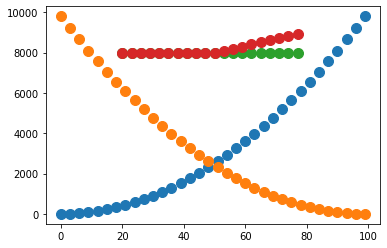

In [72]:
import numpy as np
from matplotlib import pyplot as plt

tube_1 = Tube('1',  0, 100//3)
tube_1.posX = np.arange(0, 100, 3)
tube_1.posY = [ 1/2 * 2 * (x**2) for x in tube_1.posX ]

tube_2 = Tube('2', 0, 100//3)
tube_2.posX = np.arange(0, 100, 3)
tube_2.posY = np.flip(tube_1.posY)

tube_3 = Tube('3', 20, 40)
tube_3.posX = np.arange(20, 80, 3)
tube_3.posY = np.full(len(tube_3.posX), 8000)

tube_4 = Tube('4', 20, 40)
tube_4.posX = np.arange(20, 80, 3)
tube_4.posY = np.concatenate((np.full(10, 8000), np.arange(8000, 9000, step=100)))

tube_1.plot()
tube_2.plot()
tube_3.plot()
tube_4.plot()

In [73]:
rmap = RelationsMap([tube_1, tube_2, tube_3, tube_4])
#rmap.compute()
rmap.compute()
print(rmap)

[1]:	(1)None	(2)INT	(3)None	(4)None	
[2]:	(1)INT	(2)None	(3)None	(4)None	
[3]:	(1)None	(2)None	(3)None	(4)OVL	
[4]:	(1)None	(2)None	(3)OVL	(4)None	



In [74]:
print(rmap.relations['3']['4'].sframe, rmap.relations['3']['4'].eframe)
print(rmap.relations['4']['3'].sframe, rmap.relations['4']['3'].eframe)
print(rmap.relations['1']['2'].frame)
print(rmap.relations['2']['1'].frame)

20 33
20 30
15
15


In [ ]:
class IsolatedMainNode:
    def __init__(self, tube):
        self.tube = tube

class SubNode:
    def __init__(self, tube):
        self.tube = tube


class PCG:
    """ Potential Collision Graph
    """
    
        
    @classmethod
    def from_tubes_rmap(tubes, rmap):
        
    
    
    